## Step 0: Colab env
Uploading and installing dependencies

In [42]:
!pip install archspec==0.2.3 \
asttokens==2.4.1 \
boltons==23.0.0 \
Brotli==1.0.9 \
charset-normalizer==2.0.4 \
colorama==0.4.6 \
comm==0.2.2 \
cryptography==42.0.5 \
decorator==4.4.2 \
distro==1.9.0 \
executing==2.0.1 \
frozendict==2.4.2 \
idna==3.7 \
jedi==0.19.1 \
jsonpatch==1.33 \
jsonpointer==2.1 \
nest-asyncio==1.6.0 \
packaging==23.2 \
parso==0.8.4 \
platformdirs==4.2.1 \
pluggy==1.0.0 \
pure-eval==0.2.2 \
pycosat==0.6.6 \
pycparser==2.21 \
Pygments==2.18.0 \
PySocks==1.7.1 \
requests==2.32.3 \
ruamel.yaml==0.17.21 \
stack-data==0.6.3 \
tqdm==4.66.4 \
traitlets==5.14.3 \
truststore==0.8.0 \
urllib3==2.2.2 \
zstandard==0.22.0 \
ptflops==0.7.4 \
pykan

  Using cached archspec-0.2.3-py3-none-any.whl.metadata (4.4 kB)
  Using cached boltons-23.0.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached Brotli-1.0.9.zip (510 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached charset_normalizer-2.0.4-py3-none-any.whl.metadata (11 kB)
  Using cached cryptography-42.0.5-cp39-abi3-win_amd64.whl.metadata (5.4 kB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached executing-2.0.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached frozendict-2.4.2-cp312-cp312-win_amd64.whl
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached jsonpatch

  error: subprocess-exited-with-error
  
  × Building wheel for Brotli (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      C:\Users\how2t\AppData\Local\Temp\pip-build-env-5wgyi0d7\overlay\Lib\site-packages\setuptools\_distutils\dist.py:270: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\how2t\AppData\Local\Temp\pip-build-env-5wgyi0d7\overlay\Lib\site-packages\setuptools\dist.py:493: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'build-base' will not be supported in future
              versions. Please use the underscore name 'build_base' instead.
      
              By 2025-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://set

## Step 1: Import Libraries and Set Up the Environment
Starting with libs and setting up device. If possible use GPU

In [43]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ptflops import get_model_complexity_info

from sklearn.metrics import confusion_matrix

from kan import KAN  # Make sure your KAN implementation is available
from tqdm import tqdm
from torch.amp import GradScaler


# torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
use_amp = torch.cuda.is_available()
print(f'Using device: {device}')

Using device: cpu


In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL Image -> Tensor
    transforms.Normalize((0.1307,), (0.3081,)) #normalizing dataset 
    ]) 

#Download MNIST dataset and used the transform to convert the data to tensor and normalize it
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#Create DataLoader to batch and shuffle the data using mulitprocessing
train_loader = DataLoader(dataset=train_dataset, batch_size=4096, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

In [45]:
class MLP(nn.Module):
    def __init__(self, width):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(width) - 1):
            layers.append(nn.Linear(width[i], width[i+1]))
            if i < len(width) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [46]:
# Instantiate the MLP modelMLP
modelMLP = MLP(width=[784, 10]).to(device)  
modelKAN = KAN(width=[784, 8, 10], grid=3, k=2, seed=42, device=device)  

checkpoint directory created: ./model
saving model version 0.0


In [47]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizerMLP = torch.optim.Adam(modelMLP.parameters(), lr=0.001, weight_decay=1e-4) 
optimizerKAN = torch.optim.Adam(modelKAN.parameters(), lr=0.0005)

Epoch [1/1]: 100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch [1/1] | MLP Loss: 0.7879 | MLP Test Acc: 84.34% | KAN Loss: 1.9201 | KAN Test Acc: 32.93% | Epoch Time: 65.86s


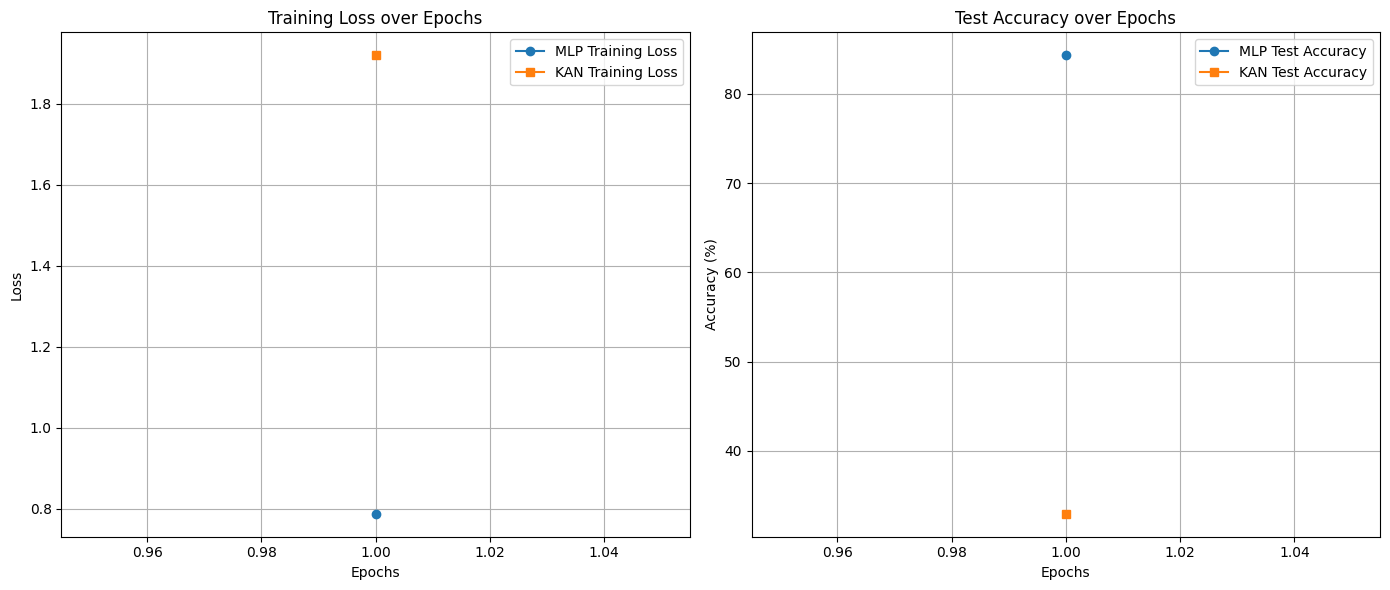

KANLayer(
  (base_fun): SiLU()
)
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '

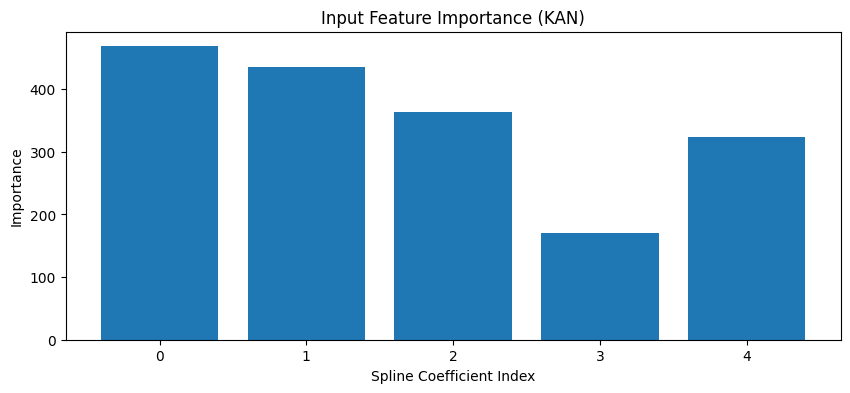

MLP Parameters: 7,850
KAN Parameters: 88,984
MLP Memory: 0.03 MB
KAN Memory: 0.36 MB
MLP Inference Time (total over test set): 4.8094s
KAN Inference Time (total over test set): 11.1322s


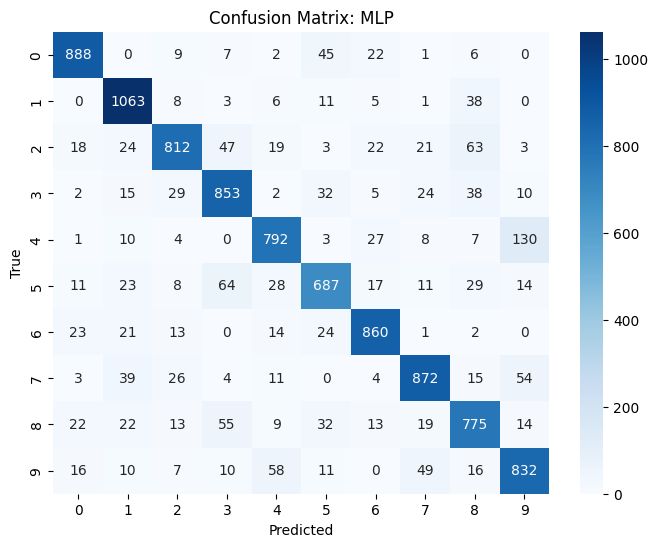

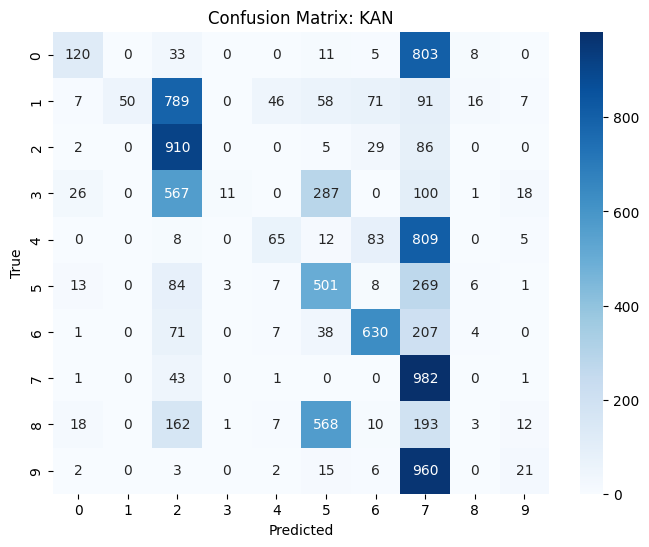

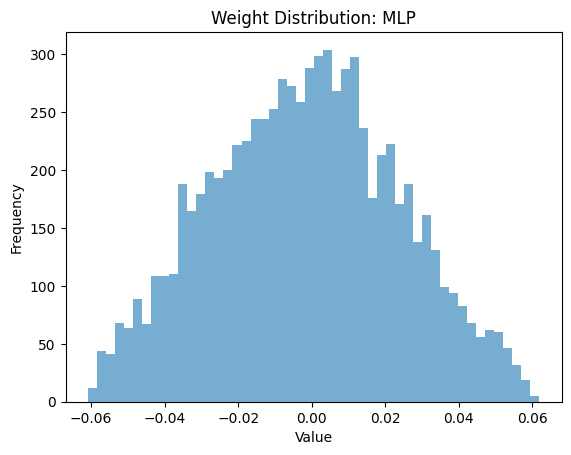

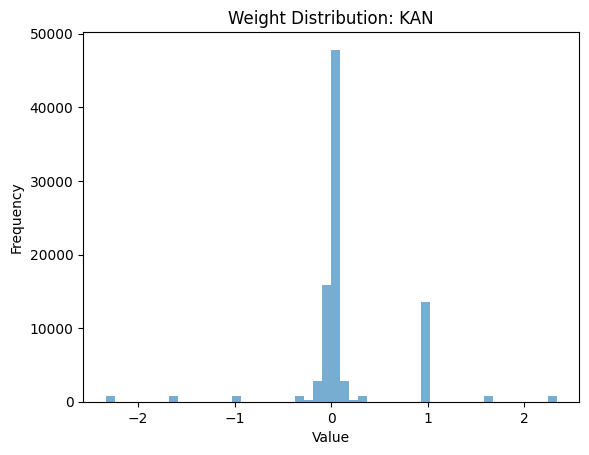

c:\Projects\KAN_thesis\envKAN\Lib\site-packages\kan\MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Projects\KAN_thesis\envKAN\Lib\site-packages\kan\MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Projects\KAN_thesis\envKAN\Lib\site-packages\kan\MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided

MLP FLOPs: 7,850
KAN FLOPs: 792


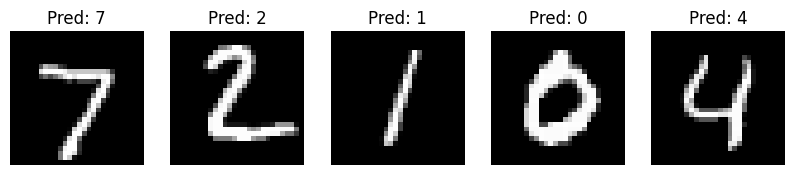

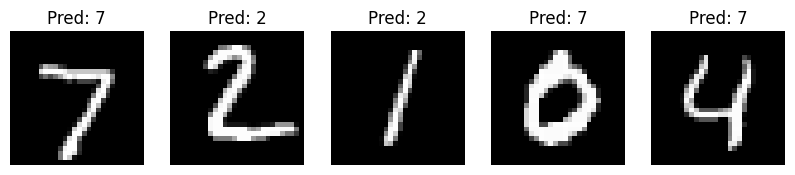

In [49]:
use_amp = torch.cuda.is_available()

scalerMLP = GradScaler(device='cuda', enabled=use_amp)
scalerKAN = GradScaler(device='cuda', enabled=use_amp)

train_losses_MLP = []
train_losses_KAN = []
test_accuracies_MLP = []
test_accuracies_KAN = []

num_epochs = 15

train_losses_MLP = []
train_losses_KAN = []
test_accuracies_MLP = []
test_accuracies_KAN = []

####################################
# 6. Main Training / Evaluation    #
####################################
for epoch in range(num_epochs):
    start_time = time.time()

    # Set both models to training mode
    modelMLP.train()
    modelKAN.train()

    running_loss_MLP = 0.0
    running_loss_KAN = 0.0

    correct_MLP = 0
    correct_KAN = 0
    total = 0

    # ---------- Training Loop ----------
    for images, labels in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]'):
        # Move data to device
        images = images.view(images.size(0), -1).to(device)  # Flatten for MLP/KAN
        labels = labels.to(device)

        ##### Train MLP #####
        optimizerMLP.zero_grad()
        with torch.autocast(device_type=device_type, enabled=use_amp):
            outputs_MLP = modelMLP(images)
            loss_MLP = criterion(outputs_MLP, labels)
        scalerMLP.scale(loss_MLP).backward()
        scalerMLP.step(optimizerMLP)
        scalerMLP.update()

        running_loss_MLP += loss_MLP.item()
        _, predicted_MLP = torch.max(outputs_MLP, 1)
        correct_MLP += (predicted_MLP == labels).sum().item()

        ##### Train KAN #####
        optimizerKAN.zero_grad()
        with torch.autocast(device_type=device_type, enabled=use_amp):
            outputs_KAN = modelKAN(images)
            loss_KAN = criterion(outputs_KAN, labels)
        scalerKAN.scale(loss_KAN).backward()
        scalerKAN.step(optimizerKAN)
        scalerKAN.update()

        running_loss_KAN += loss_KAN.item()
        _, predicted_KAN = torch.max(outputs_KAN, 1)
        correct_KAN += (predicted_KAN == labels).sum().item()

        total += labels.size(0)

    # Compute training losses
    avg_loss_MLP = running_loss_MLP / len(train_loader)
    avg_loss_KAN = running_loss_KAN / len(train_loader)
    train_losses_MLP.append(avg_loss_MLP)
    train_losses_KAN.append(avg_loss_KAN)

    # ---------- Evaluation / Testing Loop ----------
    modelMLP.eval()
    modelKAN.eval()

    correct_MLP_test = 0
    correct_KAN_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            # MLP
            outputs_MLP = modelMLP(images)
            _, predicted_MLP = torch.max(outputs_MLP, 1)
            correct_MLP_test += (predicted_MLP == labels).sum().item()

            # KAN
            outputs_KAN = modelKAN(images)
            _, predicted_KAN = torch.max(outputs_KAN, 1)
            correct_KAN_test += (predicted_KAN == labels).sum().item()

            total_test += labels.size(0)

    # Calculate test accuracies
    test_accuracy_MLP = 100 * correct_MLP_test / total_test
    test_accuracy_KAN = 100 * correct_KAN_test / total_test

    test_accuracies_MLP.append(test_accuracy_MLP)
    test_accuracies_KAN.append(test_accuracy_KAN)

    epoch_time = time.time() - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'| MLP Loss: {avg_loss_MLP:.4f} | MLP Test Acc: {test_accuracy_MLP:.2f}% '
          f'| KAN Loss: {avg_loss_KAN:.4f} | KAN Test Acc: {test_accuracy_KAN:.2f}% '
          f'| Epoch Time: {epoch_time:.2f}s')

##############################################
# 7. Plotting: Training Loss & Test Accuracy #
##############################################
plt.figure(figsize=(14, 6))

# -- Training Losses --
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_MLP, label='MLP Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), train_losses_KAN, label='KAN Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# -- Test Accuracies --
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies_MLP, label='MLP Test Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), test_accuracies_KAN, label='KAN Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##############################
# 8. Additional Functionality #
##############################

# 8a. Feature Importance for KAN
print(modelKAN.act_fun[0])
print(dir(modelKAN.act_fun[0]))

def feature_importance(kan_model):
    """
    Sums the absolute spline coefficients for each input feature and plots a bar graph.
    This version assumes that the spline parameters for the first KAN layer
    are stored in kan_model.act_fun[0].coef.
    """
    # Use the 'coef' attribute instead of 'splines'
    importance = torch.abs(kan_model.act_fun[0].coef).sum(dim=(0, 1))
    plt.figure(figsize=(10, 4))
    plt.bar(range(importance.size(0)), importance.cpu().detach().numpy())
    plt.title('Input Feature Importance (KAN)')
    plt.xlabel('Spline Coefficient Index')
    plt.ylabel('Importance')
    plt.show()
feature_importance(modelKAN)

# 8b. Model Size (Parameters, Memory) 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

mlp_params = count_parameters(modelMLP)
kan_params = count_parameters(modelKAN)

print(f"MLP Parameters: {mlp_params:,}")
print(f"KAN Parameters: {kan_params:,}")

# Float32 => 4 bytes per parameter
print(f"MLP Memory: {mlp_params * 4 / 1e6:.2f} MB")
print(f"KAN Memory: {kan_params * 4 / 1e6:.2f} MB")

# 8c. Inference Speed (on the test loader) - measure total or per batch
with torch.no_grad():
    # MLP
    start_infer_mlp = time.time()
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        _ = modelMLP(images)
    mlp_infer_time = time.time() - start_infer_mlp

    # KAN
    start_infer_kan = time.time()
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        _ = modelKAN(images)
    kan_infer_time = time.time() - start_infer_kan

print(f"MLP Inference Time (total over test set): {mlp_infer_time:.4f}s")
print(f"KAN Inference Time (total over test set): {kan_infer_time:.4f}s")

# 8d. GPU Memory Usage
if device.type == 'cuda':
    print(f"GPU Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")

# 8e. Confusion Matrix
def plot_confusion_matrix(model, loader, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1).to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(modelMLP, test_loader, "MLP")
plot_confusion_matrix(modelKAN, test_loader, "KAN")

# 8f. Parameter Distribution
def plot_weights(model, title):
    weights = []
    for param in model.parameters():
        if param.dim() > 1:  # Skip biases (dim=1)
            weights.extend(param.flatten().cpu().detach().numpy())
    plt.hist(weights, bins=50, alpha=0.6)
    plt.title(f'Weight Distribution: {title}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

plot_weights(modelMLP, "MLP")
plot_weights(modelKAN, "KAN")


def calculate_flops(model):
    dummy_input = torch.randn(1, 784).to(device)
    macs, params = get_model_complexity_info(model, (784,), as_strings=False, print_per_layer_stat=False)
    return macs

mlp_flops = calculate_flops(modelMLP)
kan_flops = calculate_flops(modelKAN)
print(f"MLP FLOPs: {mlp_flops:,}")
print(f"KAN FLOPs: {kan_flops:,}")

# 8h. (Optional) Simple MNIST Image + Prediction Visualization
def show_predictions(model, loader, num_images=5):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    with torch.no_grad():
        for images, labels in loader:
            # Take the first batch only
            images = images.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, preds = torch.max(outputs, 1)

            for i in range(num_images):
                # Reshape the i-th image from 1x28x28 -> 28x28
                axes[i].imshow(images[i].cpu().squeeze(), cmap='gray')
                axes[i].set_title(f'Pred: {preds[i].item()}')
                axes[i].axis('off')
            break
    plt.show()

show_predictions(modelMLP, test_loader)  # Example using MLP
show_predictions(modelKAN, test_loader)  # Example using KAN